In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.61.30.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.30.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.61.30.26:8470


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [4]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#getting dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [6]:
#checking train and test size
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


# EDA

In [7]:
#Look at labels for training set- they are numeric
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]



In [8]:
# function to help plot some of the pictures from the dataset
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [10]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

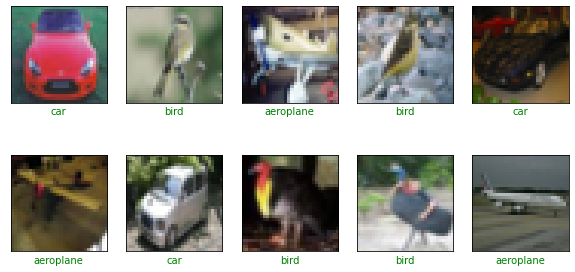

In [11]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

# Data Preprocessing

In [12]:
#use train_test_split to create validation set.
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=10
                                                                              ,shuffle=True)

In [13]:
#looking at train, validation and test set shapes
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [14]:
#scaling the train, validation and test sets by 255. Equivelant to min_max scaling

x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Helpful Model Fitting and Results Functions

In [15]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [16]:
#function to compile and train the model with various run-time tracking calculations
def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer='adam',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=512,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
         
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                    
  

    return history, model

In [17]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [18]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [19]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [20]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                     #index = [0,1,2,3,4,5,6,7,8,9], 
                     #columns = [0,1,2,3,4,5,6,7,8,9]
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 1 - ANN with 2 Dense Hidden Layer

In [21]:
#Experiment 1 model
def create_model_exp_1():
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,3)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation = "softmax"))
    return model



In [22]:
#TPU Strategy
strategy_exp_1  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [23]:
#assigning model to TPU strategy
with strategy_exp_1.scope():
    model_exp_1 = create_model_exp_1()

model_exp_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile and train
epochs=100
patience=3
model_number="1"
history_exp_1, model_exp_1 = compile_train_model(model_exp_1,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 4/88 [>.............................] - ETA: 1s - loss: 4.0918 - accuracy: 0.1108  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.1485s). Check your callbacks.


88/88 [==============================] - 8s 56ms/step - loss: 2.3409 - accuracy: 0.1863 - val_loss: 1.9537 - val_accuracy: 0.3020
Epoch 2/100
88/88 [==============================] - 2s 23ms/step - loss: 1.9993 - accuracy: 0.2788 - val_loss: 1.9492 - val_accuracy: 0.2934
Epoch 3/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8983 - accuracy: 0.3204 - val_loss: 1.8833 - val_accuracy: 0.3266
Epoch 4/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8419 - accuracy: 0.3408 - val_loss: 1.8567 - val_accuracy: 0.3372
Epoch 5/100
88/88 [==============================] - 2s 22ms/step - loss: 1.7928 - accuracy: 0.3570 - val_loss: 1.7230 - val_accuracy: 0.3828
Epoch 6/100
88/88 [==============================] - 2s 22ms/step - loss: 1.7526 - accuracy: 0.3713 - val_loss: 1.7632 - val_accuracy: 0.3686
Epoch 7/100
88/88 [==============================] - 2s 23ms/step - loss: 1.7235 - accuracy: 0.3852 - val_loss: 1.6933 - val_accuracy: 0.4044
Epoch 8/100
88/88 

In [25]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_1, model_number, epochs, patience=patience)

Model Experiment 1  Training Loss:  1.6035
Model Experiment 1  Training Accuracy:  0.4282
Model Experiment 1  Validation Loss:  1.5705
Model Experiment 1  Validation Accuracy: 0.4406


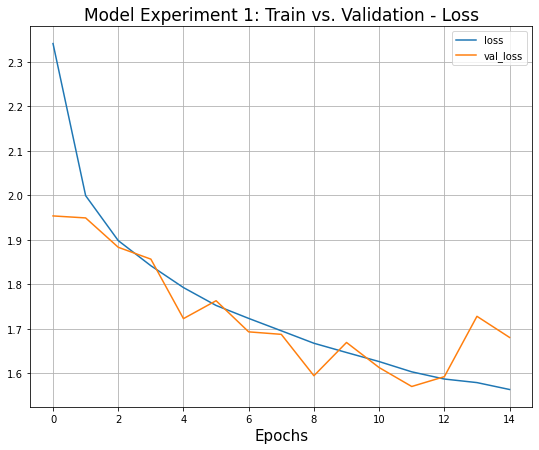

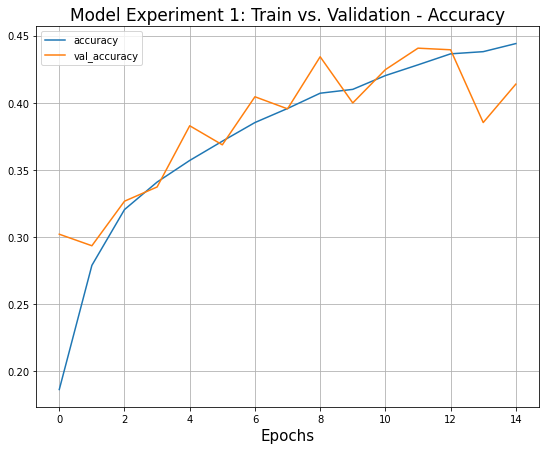

In [26]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_1, model_number)

In [27]:
#creating  classification report

#getting predictions

model_exp_1_predictions=model_exp_1.predict(x_test_norm).argmax(axis=1)
print_validation_report(y_test, model_exp_1_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1000
           1       0.60      0.50      0.54      1000
           2       0.34      0.34      0.34      1000
           3       0.35      0.25      0.29      1000
           4       0.35      0.43      0.39      1000
           5       0.42      0.32      0.36      1000
           6       0.54      0.36      0.44      1000
           7       0.43      0.54      0.48      1000
           8       0.58      0.54      0.56      1000
           9       0.40      0.64      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.44     10000
weighted avg       0.45      0.45      0.44     10000

Accuracy Score: 0.4454
Root Mean Square Error: 3.3039067783459024


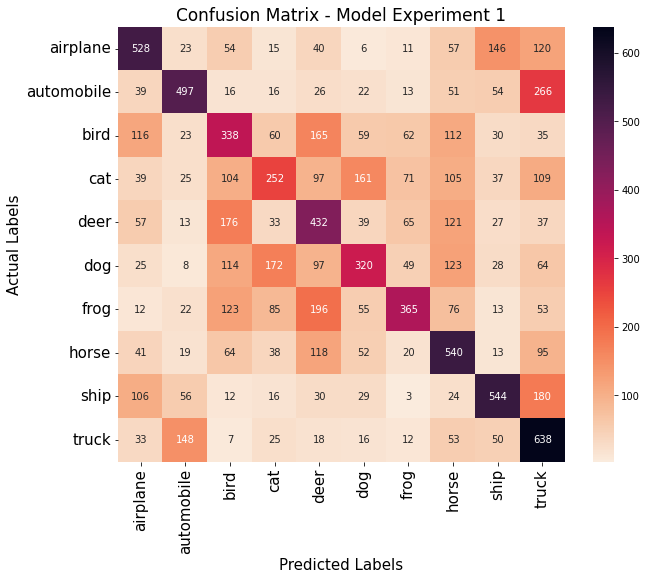

In [28]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_1, x_test_norm, y_test, model_number)

# Experiment 2 - ANN with 3 Dense Hidden Layer

In [29]:
#Experiment 2 model

def create_model_exp_2():
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,3)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation = "softmax"))
    return model



In [30]:
#TPU Strategy
strategy_exp_2  = tf.distribute.TPUStrategy(tpu) 


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [31]:
#assigning model to tpu strategy
with strategy_exp_2.scope():
    model_exp_2 = create_model_exp_2()

model_exp_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               393344    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile and train
epochs=100
patience=3
model_number="2"
history_exp_2, model_exp_2 = compile_train_model(model_exp_2,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 4/88 [>.............................] - ETA: 1s - loss: 3.4944 - accuracy: 0.0938  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.1678s). Check your callbacks.


88/88 [==============================] - 8s 55ms/step - loss: 2.2860 - accuracy: 0.1843 - val_loss: 2.0400 - val_accuracy: 0.2330
Epoch 2/100
88/88 [==============================] - 2s 23ms/step - loss: 1.9884 - accuracy: 0.2761 - val_loss: 1.9562 - val_accuracy: 0.2734
Epoch 3/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8959 - accuracy: 0.3170 - val_loss: 1.7877 - val_accuracy: 0.3628
Epoch 4/100
88/88 [==============================] - 2s 23ms/step - loss: 1.8346 - accuracy: 0.3438 - val_loss: 1.8959 - val_accuracy: 0.3258
Epoch 5/100
88/88 [==============================] - 2s 22ms/step - loss: 1.7890 - accuracy: 0.3585 - val_loss: 1.8820 - val_accuracy: 0.3378
Epoch 6/100
88/88 [==============================] - 2s 23ms/step - loss: 1.7491 - accuracy: 0.3726 - val_loss: 1.7201 - val_accuracy: 0.3810
Epoch 7/100
88/88 [==============================] - 2s 22ms/step - loss: 1.7105 - accuracy: 0.3879 - val_loss: 1.6785 - val_accuracy: 0.3940
Epoch 8/100
88/88 

In [33]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_2, model_number, epochs, patience=patience)

Model Experiment 2  Training Loss:  1.569
Model Experiment 2  Training Accuracy:  0.4422
Model Experiment 2  Validation Loss:  1.5399
Model Experiment 2  Validation Accuracy: 0.4554


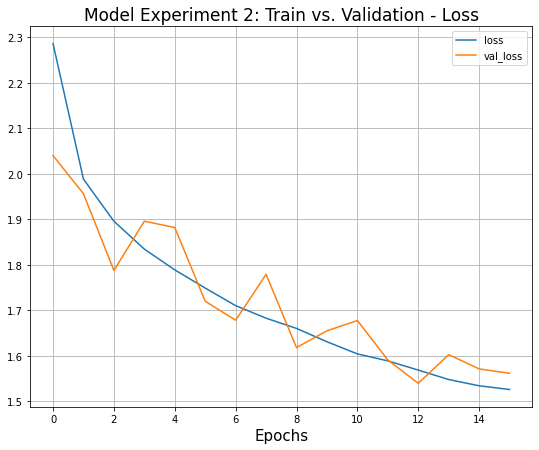

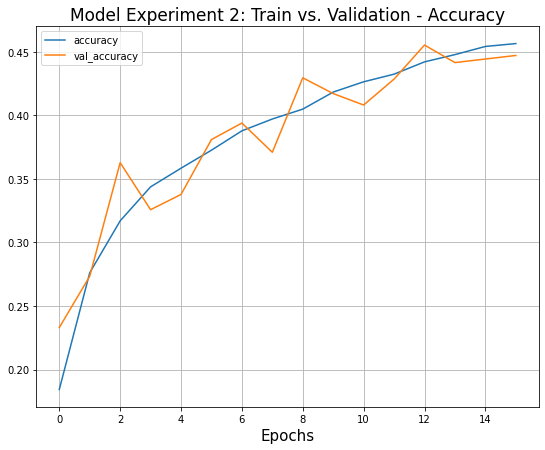

In [34]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_2, model_number)

In [35]:
#creating  classification report

#getting predictions

model_exp_2_predictions=model_exp_2.predict(x_test_norm).argmax(axis=1)
print_validation_report(y_test, model_exp_2_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.54      0.51      1000
           1       0.50      0.65      0.57      1000
           2       0.39      0.24      0.30      1000
           3       0.33      0.35      0.34      1000
           4       0.51      0.26      0.34      1000
           5       0.43      0.24      0.31      1000
           6       0.39      0.66      0.49      1000
           7       0.59      0.41      0.49      1000
           8       0.49      0.70      0.58      1000
           9       0.49      0.53      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.44     10000
weighted avg       0.46      0.46      0.44     10000

Accuracy Score: 0.4583
Root Mean Square Error: 3.2686847507827976


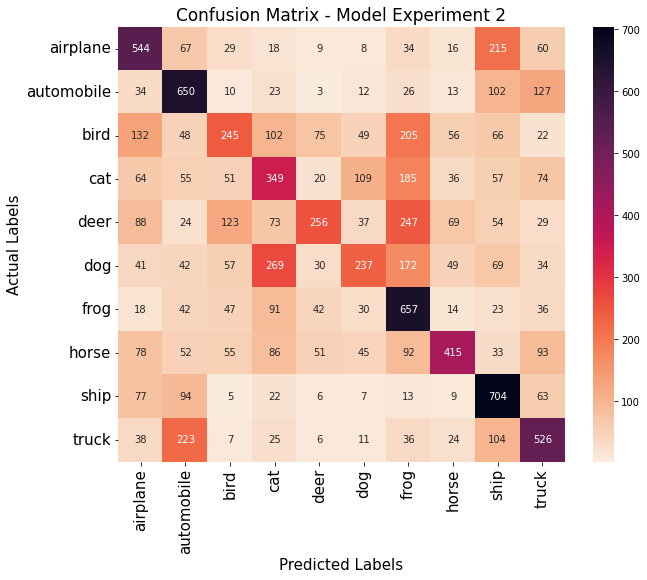

In [36]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_2, x_test_norm, y_test, model_number)

# Experiment 3 - CNN with 2 sets of Conv2D/MaxPool2D layers and 1 Dense Layer

In [37]:
#Experiment 3 model
def create_model_exp_3():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(5,5), activation="relu", padding="same", input_shape=[32,32,3]))
    model.add(MaxPool2D(2, strides=1)),
    model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(10, activation = "softmax"))
    return model



In [38]:
#TPU Strategy
strategy_exp_3  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [39]:
#assigning model to tpu strategy
with strategy_exp_3.scope():
    model_exp_3 = create_model_exp_3()

model_exp_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 230400)            0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [40]:
# Compile and train
epochs=100
patience=3
model_number="3"
history_exp_3, model_exp_3 = compile_train_model(model_exp_3,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 6/88 [=>............................] - ETA: 4s - loss: 32.2263 - accuracy: 0.1061WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.7347s). Check your callbacks.


88/88 [==============================] - 23s 190ms/step - loss: 4.1417 - accuracy: 0.2794 - val_loss: 1.5437 - val_accuracy: 0.4474
Epoch 2/100
88/88 [==============================] - 7s 75ms/step - loss: 1.8169 - accuracy: 0.3809 - val_loss: 1.5135 - val_accuracy: 0.4574
Epoch 3/100
88/88 [==============================] - 7s 76ms/step - loss: 1.4983 - accuracy: 0.4788 - val_loss: 1.3437 - val_accuracy: 0.5254
Epoch 4/100
88/88 [==============================] - 7s 75ms/step - loss: 1.3239 - accuracy: 0.5539 - val_loss: 1.2138 - val_accuracy: 0.5704
Epoch 5/100
88/88 [==============================] - 7s 74ms/step - loss: 1.1975 - accuracy: 0.6010 - val_loss: 1.1186 - val_accuracy: 0.6166
Epoch 6/100
88/88 [==============================] - 6s 63ms/step - loss: 0.9363 - accuracy: 0.6748 - val_loss: 1.2101 - val_accuracy: 0.5892
Epoch 7/100
88/88 [==============================] - 6s 64ms/step - loss: 0.7568 - accuracy: 0.7414 - val_loss: 1.1768 - val_accuracy: 0.6330
Epoch 8/100
88/8

In [41]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_3, model_number, epochs, patience=patience)

Model Experiment 3  Training Loss:  1.1975
Model Experiment 3  Training Accuracy:  0.601
Model Experiment 3  Validation Loss:  1.1186
Model Experiment 3  Validation Accuracy: 0.6166


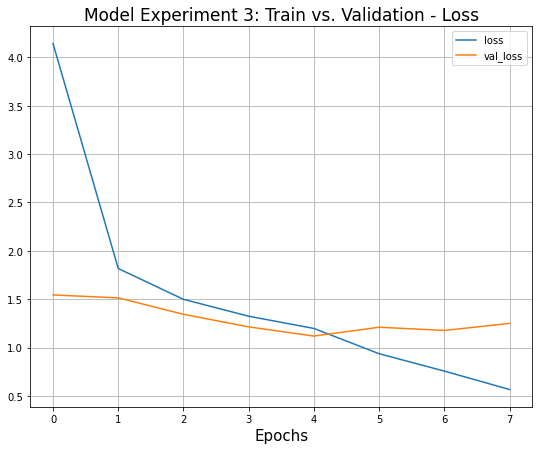

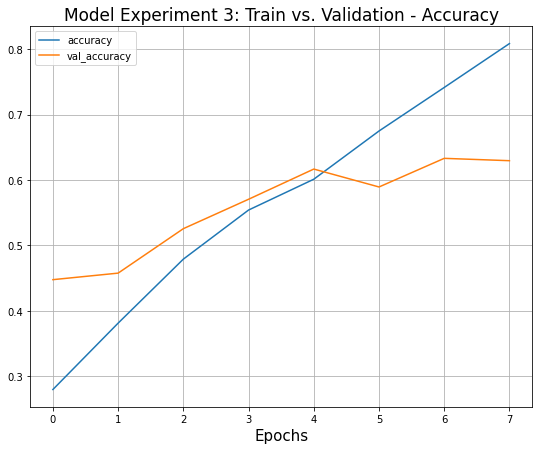

In [42]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_3, model_number)

In [43]:
#creating  classification report

#getting predictions

model_exp_3_predictions=model_exp_3.predict(x_test_norm).argmax(axis=1)
print_validation_report(y_test, model_exp_3_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1000
           1       0.70      0.79      0.74      1000
           2       0.54      0.49      0.52      1000
           3       0.57      0.28      0.38      1000
           4       0.58      0.46      0.51      1000
           5       0.53      0.52      0.53      1000
           6       0.72      0.64      0.68      1000
           7       0.50      0.83      0.63      1000
           8       0.72      0.76      0.74      1000
           9       0.70      0.67      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000

Accuracy Score: 0.6148
Root Mean Square Error: 2.685032588256612


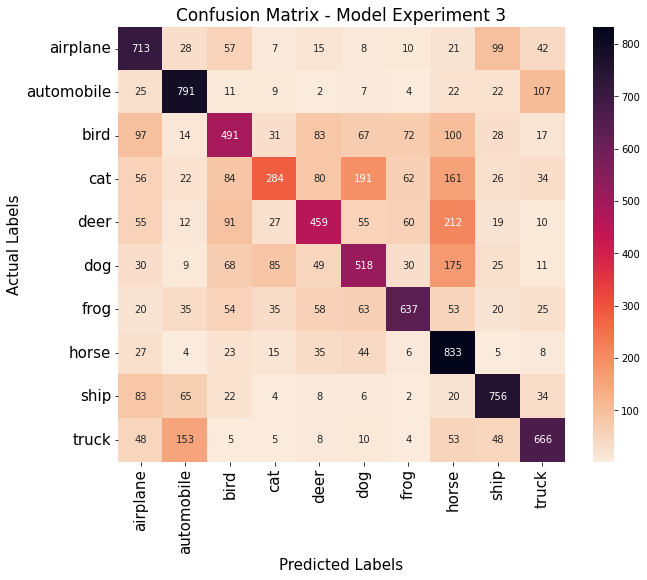

In [44]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_3, x_test_norm, y_test, model_number)

# Experiment 4 - CNN with 3 sets of Conv2D/MaxPool2D layers and 1 Dense Layer

In [58]:
#Experiment 4 model
def create_model_exp_4():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(5,5), activation="relu", padding="same", input_shape=[32,32,3]))
    model.add(MaxPool2D(2, strides=1)),
    model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Conv2D(512, kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPool2D(2, strides=1))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(10, activation = "softmax"))
    return model



In [59]:
strategy_exp_4  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [60]:
with strategy_exp_4.scope():
    model_exp_4 = create_model_exp_4()

model_exp_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 512)       1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 512)     

In [61]:
# Compile and train
epochs=100
patience=3
model_number="4"
history_exp_4, model_exp_4 = compile_train_model(model_exp_4,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 6/88 [=>............................] - ETA: 8s - loss: 107.1941 - accuracy: 0.1035WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 1.3569s). Check your callbacks.


88/88 [==============================] - 39s 336ms/step - loss: 9.6895 - accuracy: 0.1670 - val_loss: 2.0979 - val_accuracy: 0.2854
Epoch 2/100
88/88 [==============================] - 12s 134ms/step - loss: 2.2657 - accuracy: 0.2725 - val_loss: 2.0090 - val_accuracy: 0.2950
Epoch 3/100
88/88 [==============================] - 12s 133ms/step - loss: 1.9223 - accuracy: 0.3549 - val_loss: 1.6546 - val_accuracy: 0.4154
Epoch 4/100
88/88 [==============================] - 12s 134ms/step - loss: 1.5476 - accuracy: 0.4600 - val_loss: 1.4773 - val_accuracy: 0.4812
Epoch 5/100
88/88 [==============================] - 10s 112ms/step - loss: 1.3408 - accuracy: 0.5380 - val_loss: 1.5742 - val_accuracy: 0.4554
Epoch 6/100
88/88 [==============================] - 12s 134ms/step - loss: 1.1719 - accuracy: 0.5942 - val_loss: 1.2767 - val_accuracy: 0.5692
Epoch 7/100
88/88 [==============================] - 12s 134ms/step - loss: 1.0216 - accuracy: 0.6504 - val_loss: 1.0725 - val_accuracy: 0.6492
Epoc

In [62]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_4, model_number, epochs, patience=patience)

Model Experiment 4  Training Loss:  1.0216
Model Experiment 4  Training Accuracy:  0.6504
Model Experiment 4  Validation Loss:  1.0725
Model Experiment 4  Validation Accuracy: 0.6492


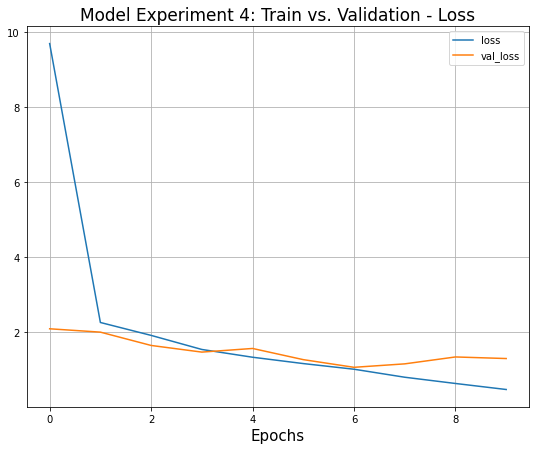

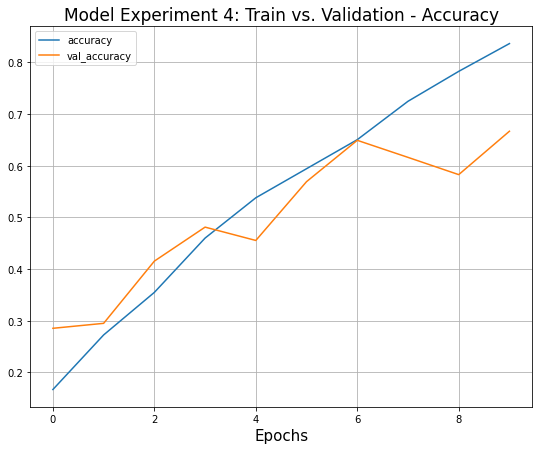

In [63]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_4, model_number)

In [64]:
#creating  classification report

#getting predictions

model_exp_4_predictions=model_exp_4.predict(x_test_norm).argmax(axis=1)
print_validation_report(y_test, model_exp_4_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      1000
           1       0.83      0.74      0.78      1000
           2       0.59      0.41      0.48      1000
           3       0.50      0.44      0.47      1000
           4       0.47      0.73      0.57      1000
           5       0.51      0.57      0.54      1000
           6       0.71      0.66      0.68      1000
           7       0.75      0.69      0.72      1000
           8       0.81      0.67      0.73      1000
           9       0.70      0.78      0.74      1000

    accuracy                           0.64     10000
   macro avg       0.66      0.64      0.64     10000
weighted avg       0.66      0.64      0.64     10000

Accuracy Score: 0.6408
Root Mean Square Error: 2.467367017693152


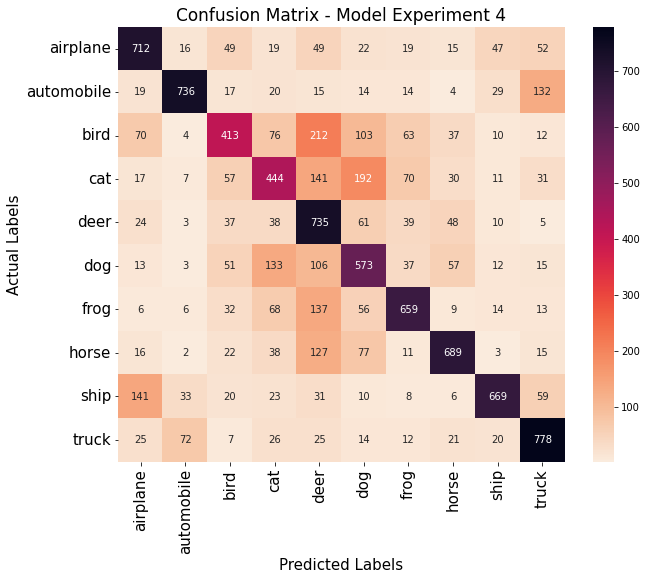

In [65]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_4, x_test_norm, y_test, model_number)